# Load data

We first start by loading the raw data for Hotel reviews and Amazon reviews.

In [2]:
import pandas as pd

# read data Amazon reviews and hotel reviews
Amazonreviews_df = pd.read_csv("AmazonReviews.csv")
reviews_df = pd.read_csv("Hotel_Reviews.csv")

# append the positive and negative text reviews
reviews_df["review"] = reviews_df["Negative_Review"] + reviews_df["Positive_Review"]

# create the label
reviews_df["is_neagtive_review"] = reviews_df["Reviewer_Score"].apply(lambda x: 1 if x < 5 else 0)
Amazonreviews_df["is_neagtive_review"] = Amazonreviews_df["Score"].apply(lambda x: 1 if x < 3 else 0)

# select only relevant columns for Hotel reviews
reviews_df = reviews_df[["review", "is_neagtive_review"]]

# select only relevant columns for Amazon reviews
Amazonreviews_df = pd.DataFrame(Amazonreviews_df,columns = ['Text','is_neagtive_review'])
Amazonreviews_df.rename(columns = {'Text':'Review'},inplace = True)


print('Hotel Reviews')
print(reviews_df.head())

print('\n')

print('Amazon Reviews')
print(Amazonreviews_df.head())



Hotel Reviews
                                              review  is_neagtive_review
0   I am so angry that i made this post available...                   1
1  No Negative No real complaints the hotel was g...                   0
2   Rooms are nice but for elderly a bit difficul...                   0
3   My room was dirty and I was afraid to walk ba...                   1
4   You When I booked with your company on line y...                   0


Amazon Reviews
                                              Review  is_neagtive_review
0  I have bought several of the Vitality canned d...                   0
1  Product arrived labeled as Jumbo Salted Peanut...                   1
2  This is a confection that has been around a fe...                   0
3  If you are looking for the secret ingredient i...                   1
4  Great taffy at a great price.  There was a wid...                   0


In [2]:
print('Hotel Reviews')
print(reviews_df['is_neagtive_review'].value_counts())

print('\n')

print('Amazon Reviews')
print(Amazonreviews_df['is_neagtive_review'].value_counts())

Hotel Reviews
0    493457
1     22281
Name: is_neagtive_review, dtype: int64


Amazon Reviews
0    486417
1     82037
Name: is_neagtive_review, dtype: int64


In [3]:
print('Hotel Reviews positive and negative ratio')
print(reviews_df['is_neagtive_review'].value_counts(normalize=True))

print('\n')

print('Amazon Reviews positive and negative ratio')
print(Amazonreviews_df['is_neagtive_review'].value_counts(normalize=True))


Hotel Reviews positive and negative ratio
0    0.956798
1    0.043202
Name: is_neagtive_review, dtype: float64


Amazon Reviews positive and negative ratio
0    0.855684
1    0.144316
Name: is_neagtive_review, dtype: float64


# Up sampling the minority class (negative) to fix the imbalance
* We can notice that there is an imbalance in both datasets Amazon and hotel. The positive class has a bigger size than the negative class which makes the negtive a minortiy class and the positive a majortiy class. 

*So we need to fix this problem by using up sampling  

*using the sklearn utility library the module resample which will help in up sampling the minortiy class so that it becomes close to the majortiy class in terms of size. 

In [3]:
from sklearn.utils import resample
#create two different dataframe of majority and minority class 
df_majority = Amazonreviews_df[(Amazonreviews_df['is_neagtive_review']==0)] 
df_minority = Amazonreviews_df[(Amazonreviews_df['is_neagtive_review']==1)] 
# upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples= 486000, # to match majority class
                                 random_state=42)  # reproducible results
# Combine majority class with upsampled minority class
Amazonreviews_df = pd.concat([df_minority_upsampled, df_majority])

In [4]:
from sklearn.utils import resample
#create two different dataframe of majority and minority class 
df_majority = reviews_df[(reviews_df['is_neagtive_review']==0)] 
df_minority = reviews_df[(reviews_df['is_neagtive_review']==1)] 
# upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples= 493000, # to match majority class
                                 random_state=42)  # reproducible results
# Combine majority class with upsampled minority class
reviews_df = pd.concat([df_minority_upsampled, df_majority])

# Sample data
* In here we will choose a sample from the data because it is very big if we take it all. Also it will take a lot of time in pre-processing and feature engineering, so we will only take 10% of the dataset which is around 48k for both datasets. 

In [5]:
reviews_df = reviews_df.sample(frac = 0.1, replace = False, random_state=42)
Amazonreviews_df = Amazonreviews_df.sample(frac = 0.1, replace = False, random_state=42)

In [6]:
print('Hotel Reviews')
print(reviews_df['is_neagtive_review'].value_counts())

print('\n')

print('Amazon Reviews')
print(Amazonreviews_df['is_neagtive_review'].value_counts())

Hotel Reviews
0    49465
1    49181
Name: is_neagtive_review, dtype: int64


Amazon Reviews
1    48670
0    48572
Name: is_neagtive_review, dtype: int64


Reviews data is sampled in order to speed up computations because data is very large around 500k entries.

# Data Pre-proccessing (Cleaning data)


In [7]:
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Harith\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Harith\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Harith\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Harith\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

To clean textual data, we call our custom 'clean_text' function that performs several transformations:
- lower the text
- tokenize the text (split the text into words) and remove the punctuation
- remove useless words that contain numbers
- remove useless stop words like 'the', 'a' ,'this' etc.
- Part-Of-Speech (POS) tagging: assign a tag to every word to define if it corresponds to a noun, a verb etc. using the WordNet lexical database
- lemmatize the text: transform every word into their root form (e.g. rooms -> room, slept -> sleep)



In [8]:
# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet
import nltk
nltk.download('stopwords')
nltk.download('omw-1.4')

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
reviews_df["review_clean"] = reviews_df["review"].apply(lambda x: clean_text(x))
Amazonreviews_df["review_clean"] = Amazonreviews_df["Review"].apply(lambda x: clean_text(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Harith\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Harith\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Feature engineering

We first start by adding sentiment analysis features because we can guess that customers reviews are highly linked to how they felt about their stay at the hotel. We use Vader, which is a part of the NLTK module designed for sentiment analysis. Vader uses a lexicon of words to find which ones are positives or negatives. It also takes into accout the context of the sentences to determine the sentiment scores. For each text, Vader retuns 4 values:
- a neutrality score
- a positivity score
- a negativity score
- an overall score that summarizes the previous scores

We will integrate those 4 values as features in our dataset.

In [9]:
# add sentiment anaylsis columns
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
reviews_df["sentiments"] = reviews_df["review"].apply(lambda x: sid.polarity_scores(x))
reviews_df = pd.concat([reviews_df.drop(['sentiments'], axis=1), reviews_df['sentiments'].apply(pd.Series)], axis=1)

Amazonreviews_df["sentiments"] = Amazonreviews_df["Review"].apply(lambda x: sid.polarity_scores(x))
Amazonreviews_df = pd.concat([Amazonreviews_df.drop(['sentiments'], axis=1), Amazonreviews_df['sentiments'].apply(pd.Series)], axis=1)

Next, we add some simple metrics for every text:
- number of characters in the text
- number of words in the text

In [10]:
# add number of characters column
reviews_df["nb_chars"] = reviews_df["review"].apply(lambda x: len(x))
Amazonreviews_df["nb_chars"] = Amazonreviews_df["Review"].apply(lambda x: len(x))

# add number of words column
reviews_df["nb_words"] = reviews_df["review"].apply(lambda x: len(x.split(" ")))
Amazonreviews_df["nb_words"] = Amazonreviews_df["Review"].apply(lambda x: len(x.split(" ")))

The next step consist in extracting vector representations for every review. The module Gensim creates a numerical vector representation of every word in the corpus by using the contexts in which they appear (Word2Vec). This is performed using shallow neural networks. What's interesting is that similar words will have similar representation vectors.

Each text can also be transformed into numerical vectors using the word vectors (Doc2Vec). Same texts will also have similar representations and that is why we can use those vectors as training features.

We first have to train a Doc2Vec model by feeding in our text data. By applying this model on our reviews, we can get those representation vectors.

In [11]:
#Hotel Reviews
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

Hotel_documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df["review_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(Hotel_documents, vector_size=1, window=5, min_count=2, workers=8)

# transform each document into a vector data
Hotel_doc2vec_df = reviews_df["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
Hotel_doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in Hotel_doc2vec_df.columns]
reviews_df = pd.concat([reviews_df, Hotel_doc2vec_df], axis=1)

In [18]:
#Amazon Reviews 
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

Amazon_documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(Amazonreviews_df["review_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(Amazon_documents, vector_size=1, window=5, min_count=2, workers=8)

# transform each document into a vector data
Amazon_doc2vec_df = Amazonreviews_df["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
Amazon_doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in Amazon_doc2vec_df.columns]
Amazonreviews_df = pd.concat([Amazonreviews_df, Amazon_doc2vec_df], axis=1)

Finally we add the TF-IDF (Term Frequency - Inverse Document Frequency) values for every word and every document.

But why not simply counting how many times each word appears in every document? The problem with this method is that it doesn't take into account the relative importance of words in the texts. A word that appears in almost every text would not likely bring useful information for analysis. On the contrary, rare words may have a lot more of meanings.

The TF-IDF metric solves this problem:

    TF computes the classic number of times the word appears in the text
    IDF computes the relative importance of this word which depends on how many texts the word can be found

We add TF-IDF columns for every word that appear in at least 10 different texts to filter some of them and reduce the size of the final output.


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews_df["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index
reviews_df_tfidf = pd.concat([reviews_df, tfidf_df], axis=1)

C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(Amazonreviews_df["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = Amazonreviews_df.index
Amazonreviews_df_tfidf = pd.concat([Amazonreviews_df, tfidf_df], axis=1)

C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [21]:
reviews_df.head()

,review,is_neagtive_review,review_clean,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0
145658,Matttess a bit hard Building and interior design,0,matttess bit hard build interior design,0.189,0.811,0.000,-0.1027,49,9,-0.113637
97936,No privacy at breakfast as they cram the tabl...,0,privacy breakfast cram table together like sha...,0.026,0.693,0.281,0.9416,288,56,-0.141519
320212,A very small room on 7th floor with a very sm...,0,small room floor small window look glass roof ...,0.084,0.718,0.199,0.7610,345,63,0.594292
422655,Had problems with shower nobs very hard to tu...,0,problem shower nobs hard turn ipod need reset ...,0.200,0.637,0.163,0.0516,99,18,0.390250
223747,As we told you we were unable for health reas...,1,tell unable health reason take book positive,0.106,0.721,0.173,0.3400,84,18,0.084747


In [22]:
Amazonreviews_df.head()

,Review,is_neagtive_review,review_clean,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0
188619,This is the third brand of coconut water I hav...,0,third brand coconut water try one taste much d...,0.005,0.827,0.168,0.9951,1769,313,0.692648
391831,This tea is a wonderful treat on a cold night....,0,tea wonderful treat cold night cinnamon aroma ...,0.000,0.652,0.348,0.9062,157,32,0.107449
93641,I've been eating these for a couple of years n...,0,i've eat couple year use sell organic supermar...,0.000,0.833,0.167,0.9521,513,99,0.621633
332374,"I personally do not like coffee of any kind, a...",0,personally like coffee kind hate around people...,0.095,0.647,0.258,0.9272,363,72,0.668047
96909,Will definitely buy again. I sent this to a de...,0,definitely buy sent deploy soldier share boy l...,0.000,0.581,0.419,0.9286,131,25,-0.128817


# Exploratory data analysis


In order to have a better understanding of our data, let's explore it a little:

In [52]:
# show is_bad_review distribution
print(reviews_df["is_neagtive_review"].value_counts())
Amazonreviews_df["is_neagtive_review"].value_counts()

0    49465
1    49181
Name: is_neagtive_review, dtype: int64


1    48670
0    48572
Name: is_neagtive_review, dtype: int64

wordcloud for Hotel Reviews


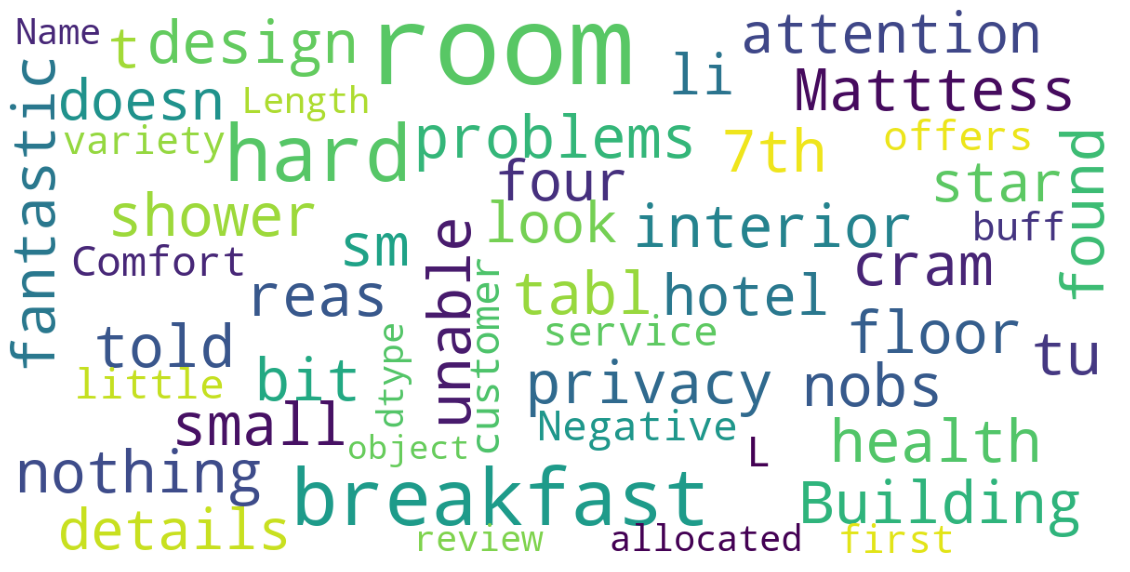

wordcloud for amazon reviews


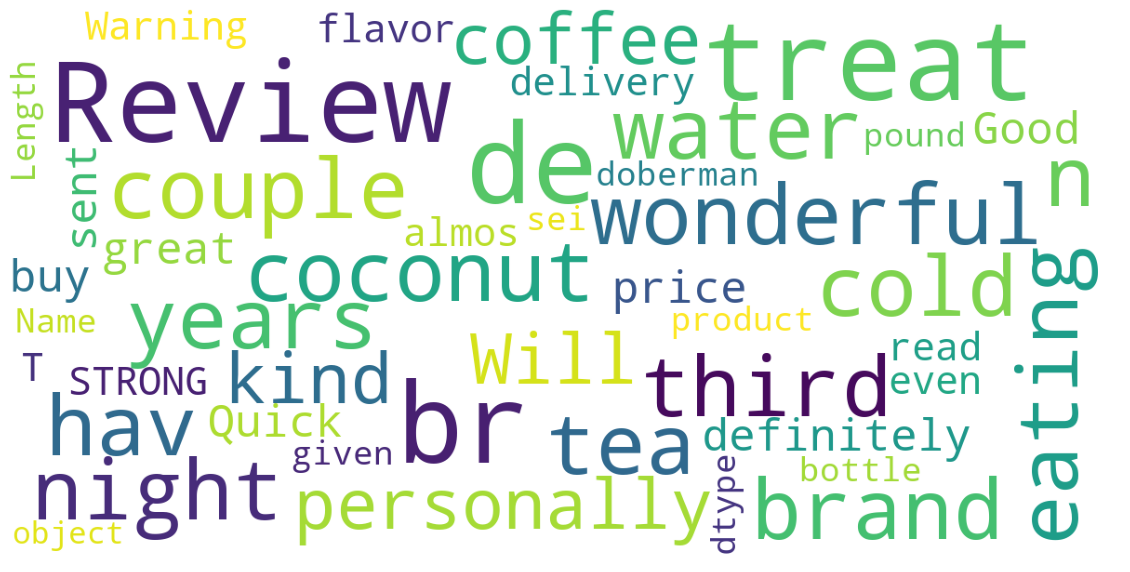

In [49]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
print('wordcloud for Hotel Reviews')
show_wordcloud(reviews_df["review"])
print('wordcloud for amazon reviews')
show_wordcloud(Amazonreviews_df["Review"])

Most of the words are indeed related to the hotels: room, staff, breakfast, etc. Some words are more related to the customer experience with the hotel stay: perfect, loved, expensive, dislike, etc.

In [58]:
# highest positive sentiment reviews (with more than 5 words)
print(reviews_df[reviews_df["nb_words"] >= 5].sort_values("pos", ascending = False)[["review", "pos"]].head(10))
print(Amazonreviews_df[Amazonreviews_df["nb_words"] >= 5].sort_values("pos", ascending = False)[["Review", "pos"]].head(10))

                                                   review    pos
31360                   Helpful friendly staffNo Positive  0.906
244782                   Price Clean Friendly Comfortable  0.902
342506                         Smile More friendly I hope  0.902
342506                         Smile More friendly I hope  0.902
342506                         Smile More friendly I hope  0.902
447295                        I like evertgingNo Positive  0.859
507248              Super Great Location  Great location   0.858
173642         Lovely breakfast friendly staffNo Positive  0.841
259234   Liked everything Fantastic welcome Beautiful ...  0.832
432530                                  Best of the best   0.808
                                                   Review    pos
469455  Thanks for this great treat for my dog as well...  0.685
341989  Delicious Coffee. Good value at the 6 pack. Wi...  0.675
491253  If you are an almond fan like me and like swee...  0.669
96706   I sent this as a 

The most positive reviews indeed correspond to some good feedbacks.

In [57]:
# lowest negative sentiment reviews (with more than 5 words)
print(reviews_df[reviews_df["nb_words"] >= 5].sort_values("neg", ascending = False)[["review", "neg"]].head(10))
print(Amazonreviews_df[Amazonreviews_df["nb_words"] >= 5].sort_values("neg", ascending = False)[["Review", "neg"]].head(10))

                                review    neg
235836         No Negative a disaster   1.000
235836         No Negative a disaster   1.000
235836         No Negative a disaster   1.000
412497             No Negative No one   0.890
412497             No Negative No one   0.890
317870  No Negative I missed breakfast  0.890
105010         No Negative i dont like  0.889
105010         No Negative i dont like  0.889
105010         No Negative i dont like  0.889
105010         No Negative i dont like  0.889
                                                   Review    neg
59774   These are good but are not sweet! Good, Good, ...  0.939
31777   This stuff is the most vile, disgusting stuff ...  0.533
464069  NONE OF THE BAR CODES Work!! AND, the coffee i...  0.509
363101  Waste of money! The candy is terrible. Nothing...  0.481
225391  Horrible experience! My wife received a broken...  0.481
190458  Very dishonest vendor. Received damaged packag...  0.458
58241   Very dishonest vendor. Received

Some errors can be found among the most negative reviews: Vader sometimes interpret 'no' or 'nothing' as negative words whereas they are sometimes used to say that there were no problems with the hotel. Fortunately, most of the reviews are indeed bad ones.

C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


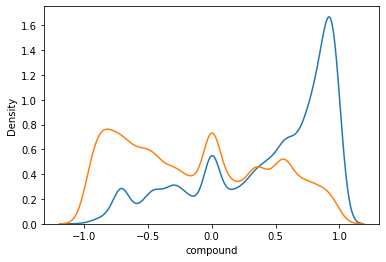

In [45]:
# plot sentiment distribution for positive and negative reviews

import seaborn as sns

for x in [0, 1]:
    subset = reviews_df[reviews_df['is_neagtive_review'] == x]
    
    # Draw the density plot
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.distplot(subset['compound'], hist = False, label = label)

The above graph shows the distribution of the reviews sentiments among good reviews and bad ones. We can see that good reviews are for most of them considered as very positive by Vader. On the contrary, bad reviews tend to have lower compound sentiment scores.

This shows us that previously computed sentiment features will be very important in our modelling part.

# Creating the models 

We first choose which features we want to use to train our model. Then we split our data into two parts:
- one to train our model
- one to assess its performances

Classifiers used : 
logistic regression
random forest
Gaussian naive bayes
Support vector machine
K-nearest neighbors (KNN)
Multi-layer perceptron (MLP)


In [43]:
# feature selection
label = "is_neagtive_review"
Hotel_ignore_cols = [ label, "review", "review_clean", ]
Amazon_ignore_cols = [ label, "Review", "review_clean",]
Hotel_features = [c for c in reviews_df.columns if c not in Hotel_ignore_cols]
Amazon_features = [c for c in Amazonreviews_df.columns if c not in Amazon_ignore_cols]

# split the data into train and test
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_trainamazon, X_testamazon, y_trainamazon, y_testamazon = train_test_split(Amazonreviews_df[Amazon_features], Amazonreviews_df[label], test_size = 0.2, random_state = 476)
X_trainhotel, X_testhotel, y_trainhotel, y_testhotel = train_test_split(reviews_df[Hotel_features], reviews_df[label], test_size = 0.2, random_state = 476)

# Logistic Regression 

In [24]:
#Train on hotel and test on hotel using LogisticRegression classifier 
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression(solver='lbfgs', max_iter=1000000)
from sklearn.metrics import classification_report
clf = log_model
# fit
clf.fit(X_trainhotel ,y_trainhotel)
# predict
y_pred = clf.predict(X_testhotel)
print(classification_report(y_pred, y_testhotel))

              precision    recall  f1-score   support

           0       0.76      0.72      0.74     10391
           1       0.71      0.74      0.72      9339

    accuracy                           0.73     19730
   macro avg       0.73      0.73      0.73     19730
weighted avg       0.73      0.73      0.73     19730



In [25]:
#Train on amazon and test on amazon using LogisticRegression classifier 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
log_model = LogisticRegression(solver='lbfgs', max_iter=9999999999)
clf = log_model
# fit
clf.fit(X_trainamazon ,y_trainamazon)
# predict
y_pred = clf.predict(X_testamazon)
print(classification_report(y_pred, y_testamazon))

              precision    recall  f1-score   support

           0       0.77      0.75      0.76     10066
           1       0.73      0.76      0.74      9383

    accuracy                           0.75     19449
   macro avg       0.75      0.75      0.75     19449
weighted avg       0.75      0.75      0.75     19449



In [26]:
#Train on hotel and test on amazon using LogisticRegression classifier 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
clf = log_model
# fit
clf.fit(X_trainhotel ,y_trainhotel)
# predict
y_pred = clf.predict(X_testamazon)
print(classification_report(y_pred, y_testamazon))

              precision    recall  f1-score   support

           0       0.81      0.68      0.74     11680
           1       0.61      0.76      0.68      7769

    accuracy                           0.71     19449
   macro avg       0.71      0.72      0.71     19449
weighted avg       0.73      0.71      0.72     19449



# GaussianNB classifier 

In [27]:
#Train on hotel and test on amazon using GaussianNB classifier 
from sklearn.naive_bayes import GaussianNB 
clf = GaussianNB()
# fit
clf.fit(X_trainhotel, y_trainhotel)
# predict
y_pred=clf.predict(X_testamazon)
print(classification_report(y_pred, y_testamazon))


              precision    recall  f1-score   support

           0       0.61      0.72      0.66      8278
           1       0.76      0.66      0.70     11171

    accuracy                           0.68     19449
   macro avg       0.68      0.69      0.68     19449
weighted avg       0.70      0.68      0.69     19449



In [28]:
#Train on amazon and test on amazon using GaussianNB classifier 
from sklearn.naive_bayes import GaussianNB 
clf = GaussianNB()
# fit
clf.fit(X_trainamazon, y_trainamazon)
# predict
y_pred=clf.predict(X_testamazon)
print(classification_report(y_pred, y_testamazon))


              precision    recall  f1-score   support

           0       0.81      0.70      0.75     11330
           1       0.65      0.78      0.71      8119

    accuracy                           0.73     19449
   macro avg       0.73      0.74      0.73     19449
weighted avg       0.75      0.73      0.74     19449



In [29]:
#Train on hotel and test on hotel using GaussianNB classifier 
from sklearn.naive_bayes import GaussianNB 
clf = GaussianNB()
# fit
clf.fit(X_trainhotel, y_trainhotel)
# predict
y_pred=clf.predict(X_testhotel)
print(classification_report(y_pred, y_testhotel))


              precision    recall  f1-score   support

           0       0.75      0.71      0.73     10458
           1       0.69      0.73      0.71      9272

    accuracy                           0.72     19730
   macro avg       0.72      0.72      0.72     19730
weighted avg       0.72      0.72      0.72     19730



# Random Forset Classifier

In [30]:
# train on hotel and test on amazon using random forest classifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
# fit
rf.fit(X_trainhotel, y_trainhotel)
# predict
y_pred=rf.predict(X_testamazon)
print(classification_report(y_pred, y_testamazon))

              precision    recall  f1-score   support

           0       0.81      0.69      0.74     11490
           1       0.63      0.76      0.69      7959

    accuracy                           0.72     19449
   macro avg       0.72      0.72      0.71     19449
weighted avg       0.73      0.72      0.72     19449



In [31]:
# train on amazon and test on amazon using random forest classifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
# fit
rf.fit(X_trainamazon, y_trainamazon)
# predict
y_pred=rf.predict(X_testamazon)
print(classification_report(y_pred, y_testamazon))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      9216
           1       0.87      0.82      0.84     10233

    accuracy                           0.84     19449
   macro avg       0.84      0.84      0.84     19449
weighted avg       0.84      0.84      0.84     19449



In [32]:
# train on hotel and test on hotel using random forest classifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
# fit
rf.fit(X_trainhotel, y_trainhotel)
# predict
y_pred=rf.predict(X_testhotel)
print(classification_report(y_pred, y_testhotel))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87      8846
           1       0.93      0.83      0.88     10884

    accuracy                           0.87     19730
   macro avg       0.87      0.88      0.87     19730
weighted avg       0.88      0.87      0.87     19730



# Support Vector Machine classifier

In [72]:
# train on hotel and test on amazon using Support Vector Machine classifier
from sklearn import svm
clf = svm.SVC()
# fit
clf.fit(X_trainhotel, y_trainhotel)
# predict
y_pred = clf.predict(X_testamazon)
print(classification_report(y_pred, y_testamazon))

              precision    recall  f1-score   support

           0       0.82      0.70      0.76     11495
           1       0.64      0.78      0.70      7954

    accuracy                           0.73     19449
   macro avg       0.73      0.74      0.73     19449
weighted avg       0.75      0.73      0.73     19449



In [73]:
# train on amazon and test on amazon using Support Vector Machine classifier
from sklearn import svm
clf = svm.SVC()
# fit
clf.fit(X_trainamazon, y_trainamazon)
# predict
y_pred = clf.predict(X_testamazon)
print(classification_report(y_pred, y_testamazon))

              precision    recall  f1-score   support

           0       0.77      0.75      0.76     10094
           1       0.74      0.76      0.75      9355

    accuracy                           0.75     19449
   macro avg       0.75      0.75      0.75     19449
weighted avg       0.75      0.75      0.75     19449



In [74]:
# train on hotel and test on hotel using Support Vector Machine classifier
from sklearn import svm
clf = svm.SVC()
# fit
clf.fit(X_trainhotel, y_trainhotel)
# predict
y_pred = clf.predict(X_testhotel)
print(classification_report(y_pred, y_testhotel))

              precision    recall  f1-score   support

           0       0.69      0.78      0.73      8880
           1       0.80      0.72      0.76     10850

    accuracy                           0.74     19730
   macro avg       0.74      0.75      0.74     19730
weighted avg       0.75      0.74      0.74     19730



# K nearsest Neighbor Classifier

In [44]:
# train on hotel and test on amazon using K nearsest Neighbor Classifier
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=5)
# fit
clf.fit(X_trainhotel ,y_trainhotel)
# predict
y_pred = clf.predict(X_testamazon)
print(classification_report(y_pred, y_testamazon))

              precision    recall  f1-score   support

           0       0.63      0.63      0.63      9814
           1       0.62      0.62      0.62      9635

    accuracy                           0.63     19449
   macro avg       0.63      0.63      0.63     19449
weighted avg       0.63      0.63      0.63     19449



In [34]:
# train on hotel and test on hotel using K nearsest Neighbor Classifier
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=5)
# fit
clf.fit(X_trainhotel ,y_trainhotel)
# predict
y_pred = clf.predict(X_testhotel)
print(classification_report(y_pred, y_testhotel))

              precision    recall  f1-score   support

           0       0.70      0.78      0.74      8868
           1       0.80      0.72      0.76     10862

    accuracy                           0.75     19730
   macro avg       0.75      0.75      0.75     19730
weighted avg       0.76      0.75      0.75     19730



In [35]:
# train on amazon and test on amazon using K nearsest Neighbor Classifier
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=5)
# fit
clf.fit(X_trainamazon ,y_trainamazon)
# predict
y_pred = clf.predict(X_testamazon)
print(classification_report(y_pred, y_testamazon))

              precision    recall  f1-score   support

           0       0.71      0.71      0.71      9791
           1       0.71      0.71      0.71      9658

    accuracy                           0.71     19449
   macro avg       0.71      0.71      0.71     19449
weighted avg       0.71      0.71      0.71     19449



# Multi-layer Perceptron classifier 

In [61]:
label = "is_neagtive_review"
Hotel_ignore_cols = [ label, "review", "review_clean"]
Hotel_features = [c for c in reviews_df_tfidf.columns if c not in Hotel_ignore_cols]

from sklearn.model_selection import train_test_split

X_trainhotel, X_testhotel, y_trainhotel, y_testhotel = train_test_split(reviews_df_tfidf[Hotel_features], reviews_df_tfidf[label], test_size = 0.2, random_state = 476)

from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(256, 32, 8),max_iter=40,early_stopping=True,verbose=True,tol=0.000005,n_iter_no_change=5)
mlp.fit(X_trainhotel, y_trainhotel)

from sklearn.metrics import classification_report, confusion_matrix
mlp_predictions = mlp.predict(X_testhotel)
print(confusion_matrix(y_testhotel,mlp_predictions))
print(classification_report(y_testhotel,mlp_predictions))

Iteration 1, loss = 0.67857710


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.791688
Iteration 2, loss = 0.41306071


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.860872
Iteration 3, loss = 0.33624426


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.846680
Iteration 4, loss = 0.32405520


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.834389
Iteration 5, loss = 0.30675251


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.869868
Iteration 6, loss = 0.29347191


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.870375
Iteration 7, loss = 0.29256366


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.869488
Iteration 8, loss = 0.28049497


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.862392
Iteration 9, loss = 0.27620927


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.875317
Iteration 10, loss = 0.26667946


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.876964
Iteration 11, loss = 0.26026006


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.879752
Iteration 12, loss = 0.24378440


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.831348
Iteration 13, loss = 0.23683011


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.876204
Iteration 14, loss = 0.22547953


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.875190
Iteration 15, loss = 0.22557664


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.884313
Iteration 16, loss = 0.20939993


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.868474
Iteration 17, loss = 0.20157249


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.874683
Iteration 18, loss = 0.19003727


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.891282
Iteration 19, loss = 0.18855042


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.888495
Iteration 20, loss = 0.18223410


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.896604
Iteration 21, loss = 0.17124834


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.889888
Iteration 22, loss = 0.16655735


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.896224
Iteration 23, loss = 0.15978368


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.891662
Iteration 24, loss = 0.15638163


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.881779
Iteration 25, loss = 0.14250542


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.846807
Iteration 26, loss = 0.14561026


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.889508
Validation score did not improve more than tol=0.000005 for 5 consecutive epochs. Stopping.
[[8482 1457]
 [ 763 9028]]
              precision    recall  f1-score   support

           0       0.92      0.85      0.88      9939
           1       0.86      0.92      0.89      9791

    accuracy                           0.89     19730
   macro avg       0.89      0.89      0.89     19730
weighted avg       0.89      0.89      0.89     19730



In [36]:
label = "is_neagtive_review"
Amazon_ignore_cols = [ label, "Review", "review_clean"]
Amazon_features = [c for c in Amazonreviews_df_tfidf.columns if c not in Amazon_ignore_cols]

# split the data into train and test
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_trainamazon, X_testamazon, y_trainamazon, y_testamazon = train_test_split(Amazonreviews_df_tfidf[Amazon_features], Amazonreviews_df_tfidf[label], test_size = 0.2, random_state = 476)


from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(256, 32, 8),max_iter=40,early_stopping=True,verbose=True,tol=0.000005,n_iter_no_change=5)
mlp.fit(X_trainamazon, y_trainamazon)

from sklearn.metrics import classification_report, confusion_matrix
mlp_predictions = mlp.predict(X_testamazon)
print(confusion_matrix(y_testamazon,mlp_predictions))
print(classification_report(y_testamazon,mlp_predictions))

Iteration 1, loss = 0.54630270


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.774936
Iteration 2, loss = 0.38456699


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.685861
Iteration 3, loss = 0.37093618


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.870566
Iteration 4, loss = 0.32224610


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.799614
Iteration 5, loss = 0.29362095


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.849614
Iteration 6, loss = 0.29097596


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.873650
Iteration 7, loss = 0.28385811


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.753470
Iteration 8, loss = 0.29121777


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.855270
Iteration 9, loss = 0.27220719


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.815938
Iteration 10, loss = 0.27635686


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.876992
Iteration 11, loss = 0.26173836


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.874936
Iteration 12, loss = 0.25051574


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.844216
Iteration 13, loss = 0.24885138


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.871080
Iteration 14, loss = 0.24432313


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.877121
Iteration 15, loss = 0.24279601


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.855656
Iteration 16, loss = 0.24964331


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.857712
Iteration 17, loss = 0.23479327


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.866195
Iteration 18, loss = 0.23766872


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.873393
Iteration 19, loss = 0.23775447


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.854370
Iteration 20, loss = 0.21449983


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.859383
Validation score did not improve more than tol=0.000005 for 5 consecutive epochs. Stopping.
[[8638 1156]
 [1271 8384]]
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      9794
           1       0.88      0.87      0.87      9655

    accuracy                           0.88     19449
   macro avg       0.88      0.88      0.88     19449
weighted avg       0.88      0.88      0.88     19449



In [61]:
label = "is_neagtive_review"
Amazon_ignore_cols = [ label, "Review", "review_clean"]
Amazon_features = [c for c in Amazonreviews_df.columns if c not in Amazon_ignore_cols]
Hotel_ignore_cols = [ label, "review", "review_clean"]
Hotel_features = [c for c in reviews_df.columns if c not in Hotel_ignore_cols]
# split the data into train and test
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_trainamazon, X_testamazon, y_trainamazon, y_testamazon = train_test_split(Amazonreviews_df[Amazon_features], Amazonreviews_df[label], test_size = 0.2, random_state = 476)
X_trainhotel, X_testhotel, y_trainhotel, y_testhotel = train_test_split(reviews_df[Hotel_features], reviews_df[label], test_size = 0.2, random_state = 476)


from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(256, 32, 8),max_iter=40,early_stopping=True,verbose=True,tol=0.000005,n_iter_no_change=5)
mlp.fit(X_trainhotel, y_trainhotel)

from sklearn.metrics import classification_report, confusion_matrix
mlp_predictions = mlp.predict(X_testamazon)
print(confusion_matrix(y_testamazon,mlp_predictions))
print(classification_report(y_testamazon,mlp_predictions))

Iteration 1, loss = 0.76861656
Validation score: 0.522554


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 2, loss = 0.55909473
Validation score: 0.725165


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 3, loss = 0.53487885
Validation score: 0.720983


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 4, loss = 0.52630975
Validation score: 0.706285


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 5, loss = 0.51896371
Validation score: 0.730740


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 6, loss = 0.51860976
Validation score: 0.730360


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 7, loss = 0.51453661
Validation score: 0.736062


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 8, loss = 0.51209225
Validation score: 0.739483


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 9, loss = 0.50957610
Validation score: 0.723011


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 10, loss = 0.50648005
Validation score: 0.721744


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 11, loss = 0.50363814
Validation score: 0.740497


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 12, loss = 0.50450511
Validation score: 0.743031


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 13, loss = 0.50409337
Validation score: 0.741891


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 14, loss = 0.50320689
Validation score: 0.730613


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 15, loss = 0.50145783
Validation score: 0.715028


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 16, loss = 0.50163034
Validation score: 0.746706


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 17, loss = 0.49920221
Validation score: 0.739990


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 18, loss = 0.50227087
Validation score: 0.728459


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 19, loss = 0.49913711
Validation score: 0.749240


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 20, loss = 0.49683487
Validation score: 0.740497


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 21, loss = 0.49878232
Validation score: 0.743918


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 22, loss = 0.49651091
Validation score: 0.732767


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 23, loss = 0.49683196
Validation score: 0.751140


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 24, loss = 0.49457894
Validation score: 0.749366


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 25, loss = 0.49275468
Validation score: 0.746706


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 26, loss = 0.49315382
Validation score: 0.752914


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 27, loss = 0.49235797
Validation score: 0.745945


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 28, loss = 0.49379810
Validation score: 0.737329


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 29, loss = 0.49273310
Validation score: 0.743538


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 30, loss = 0.49370659
Validation score: 0.750380


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 31, loss = 0.48858258
Validation score: 0.753675


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 32, loss = 0.49009749
Validation score: 0.751267


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 33, loss = 0.49004051
Validation score: 0.742777


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 34, loss = 0.48838641
Validation score: 0.751647


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 35, loss = 0.48824628
Validation score: 0.751521


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 36, loss = 0.48850464
Validation score: 0.750887


C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 37, loss = 0.48871217
Validation score: 0.743284
Validation score did not improve more than tol=0.000005 for 5 consecutive epochs. Stopping.
[[7403 2391]
 [2798 6857]]
              precision    recall  f1-score   support

           0       0.73      0.76      0.74      9794
           1       0.74      0.71      0.73      9655

    accuracy                           0.73     19449
   macro avg       0.73      0.73      0.73     19449
weighted avg       0.73      0.73      0.73     19449



C:\Users\Harith\PycharmProjects\NLP-PROJECT\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
